In [30]:
from abc import ABC, abstractmethod
from typing import Optional, List, Type, Tuple, Dict
import math

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes._axes import Axes
import torch
import torch.nn as nn
import torch.distributions as D
from tqdm import trange
from einops import einsum
from torch.func import vmap, jacrev
from tqdm import tqdm
import seaborn as sns
from sklearn.datasets import make_moons, make_circles
from torchvision import datasets, transforms
from torchvision.utils import make_grid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class Sampleable(ABC):
    @abstractmethod
    def sample(self, n_samples: int):
        pass 
    
class Simulator(ABC):
    @abstractmethod 
    def step(self, x, h, t):
        pass 
    
    @torch.no_grad()
    def simulate_with_trajectory(self, x0, ts):
        # ts: [nts, bs, 1]
        # x0: [bs, 2]
        tjs = [x0.clone()] 
        for idx in range(1, ts.shape[0]):
            t = ts[idx - 1, :] # [bs, 1]
            h = ts[idx, :] - t # [bs, 1]
            x0 = self.step(x0, h, t) # [bs, 2]
            tjs.append(x0.clone())
        return torch.stack(tjs, dim=1) # [bs,nts,2]

class ODE(ABC):
    @abstractmethod 
    def drift_term(self, x, t):
        pass 

class EulerSampler(Simulator):
    def __init__(self, ode: ODE):
        self.ode = ode 
    
    def step(self, x, h, t):
        return x + self.ode.drift_term(x, t) * h

class SDE(ABC):
    @abstractmethod
    def drift_term(self, x, t):
        pass 
    
    @abstractmethod 
    def diff_term(self, x, t):
        pass 

class EulerMarySampler(Simulator):
    def __init__(self, sde: SDE):
        self.sde = sde 
        
    def step(self, x, h, t):
        return x + self.sde.drift_term(x, t) * h + self.sde.diff_term(x, t) * torch.sqrt(h) * torch.randn_like(x)


In [4]:
class Alpha(ABC):
    def __init__(self):
        assert torch.allclose(
            self(torch.zeros(1,1)), torch.zeros(1,1)
        )
        assert torch.allclose(
            self(torch.ones(1,1)), torch.ones(1,1)
        )
    @abstractmethod
    def __call__(self, t):
        pass 
    
    def dt(self, t):
        t = t.unsqueeze(-1) # the last dimension must be 1 for broadcasting 
        return vmap(jacrev(t)).view(-1, 1)

class Beta(ABC):
    def __init__(self):
        assert torch.allclose(
            self(torch.zeros(1,1)), torch.ones(1,1)
        )
        assert torch.allclose(
            self(torch.ones(1,1)), torch.zeros(1,1)
        )
    @abstractmethod 
    def __call__(self, t):
        pass 
    
    def dt(self, t):
        t = t.unsqueeze(-1)
        return vmap(jacrev(self))(t).view(-1, 1)

class LinearAlpha(Alpha):
    def __call__(self, t):
        return t
    
    def dt(self, t):
        return torch.ones_like(t)

class LinearBeta(Beta):
    def __call__(self, t):
        return 1 - t

    def dt(self, t):
        return -torch.ones_like(t)

class SqrtBeta(Beta):
    def __call__(self, t):
        return torch.sqrt(1 - t)
    
    def dt(self, t):
        return - 0.5 / (torch.sqrt(1 - t) + 1e-4)

In [5]:
class CPP(nn.Module, ABC):
    def __init__(self, p_simple: Sampleable, p_data: Sampleable):
        super().__init__()
        self.p_simple = p_simple
        self.p_data = p_data

    def sample_marginal_path(self, t: torch.Tensor) -> torch.Tensor:
        """
        sample randomly from the data distribution 
        sample from the path between data point z and starting point 
        """
        num_samples = t.shape[0]
        z, _ = self.sample_conditioning_variable(num_samples)  
        x = self.sample_conditional_path(z, t) 
        return x

    @abstractmethod
    def sample_conditioning_variable(self, num_samples: int) -> [torch.Tensor, Optional[torch.Tensor]]: 
        """
        sample (z, y) from the join distribution of data and label p(z, y)
        """
        pass
    
    @abstractmethod
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        sample from the path between data point z and initial distribution data point P(.|z)
        """
        pass 
        
    @abstractmethod
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        the path which is being followed by the conditional probability path u(x|z)
        """
        pass

    @abstractmethod
    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Compute: derivative(log(p(x|z)))
        """
        pass

In [6]:
class IsotropicGaussian(nn.Module, Sampleable):
    def __init__(self, shape: torch.Tensor, std: float):
        super().__init__()
        self.shape = shape
        self.std = std 
    
    def sample(self, n_samples: int):
        return std * torch.randn_like(n_samples, *self.shape)

In [7]:
class MNISTSampler(nn.Module, Sampleable):
    def __init__(self):
        self.dataset = datasets.MNIST(
            root='../labs/data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
            ])
        )
        
    def sample(self, n_samples):
        indices = torch.randperm(len(self.dataset))[:n_samples]
        samples, label = zip(*[self.dataset[i] for i in indices])
        samples, label = torch.stack(samples), torch.tensor(label, dtype=torch.int64)
        return samples, label
        

In [8]:
class GCPP(CPP):
    def __init__(self, p_init: Sampleable, p_data: Sampleable, alpha: LinearAlpha, beta: LinearBeta):
        super().__init__(p_init, p_data)
        self.alpha = alpha
        self.beta = beta
        
    def sample_conditioning_variable(self, n_sample: int) -> torch.Tensor:
        return self.p_data.sample(n_sample)

    def sample_conditional_path(self, z, t):
        # sampling from standard gaussian randn() and then changing 
        # standard deviation and mean of that to represent sampling 
        # from isotropic gaussian 
        return self.alpha(t) * z + self.beta(t) * torch.randn_like(z)

    def conditional_vector_field(self, x, z, t):
        alpha_t = self.alpha(t)
        alpha_dt = self.alpha.dt(t)
        beta_t = self.beta(t)
        beta_dt = self.beta.dt(t)
        return (alpha_dt - beta_dt/beta_t * alpha_t) * z + (beta_dt / beta_t) * x

    def conditional_score(self, x, z, t):
        return (self.alpha(t) * z - x) / self.beta(t) ** 2

In [9]:
mnist = MNISTSampler()
samples, labels = mnist.sample(10)
samples.shape, labels.shape

(torch.Size([10, 1, 32, 32]), torch.Size([10]))

In [10]:
path = GCPP(
    p_init = IsotropicGaussian(shape=(1,32,32), std=1.0),
    p_data = MNISTSampler(),
    alpha = LinearAlpha(), 
    beta = LinearBeta()
)

In [11]:
samples, labels = path.sample_conditioning_variable(10)
samples.shape, labels.shape

(torch.Size([10, 1, 32, 32]), torch.Size([10]))

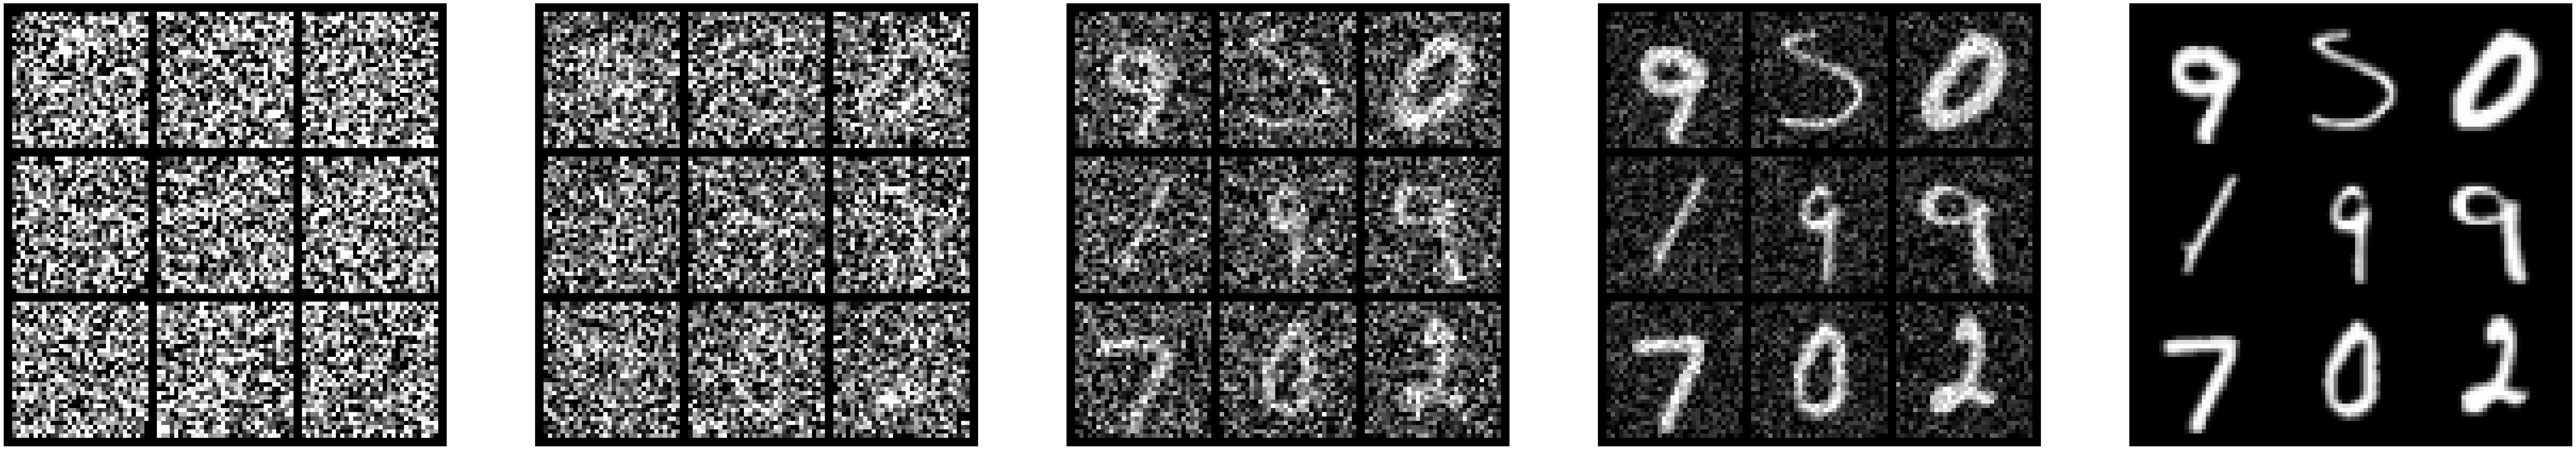

In [12]:
n_rows = 3
n_samples = 9
n_ts = 5

ts = torch.linspace(0, 1, n_ts)
z, _ = path.sample_conditioning_variable(n_samples)

fig, axes = plt.subplots(1, n_ts, figsize=(6 * n_rows * n_ts, 6 * n_rows))
for idx in range(ts.shape[0]):
    t = ts[idx] # [1]
    t = t.view(-1, 1, 1, 1).repeat(n_samples, 1, 1, 1) # [n_samples, 1, 1, 1]
    xt = path.sample_conditional_path(z, t) # z:[n_samples, 1, 32, 32], t: [n_samples, 1, 1, 1] xt: [n_samples, 1, 32, 32]
    grid = make_grid(xt, nrow=n_rows, normalize=True, value_range=(-1,1)) # grid: [3, 3, 1, 32, 32]
    axes[idx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray") # grid: [3, 3, 32, 32, 1]
    axes[idx].axis("off")
plt.show()
    

In [13]:
ts

tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])

In [14]:
tx = ts[4].view(-1, 1, 1, 1).repeat(10000, 1, 1, 1) # [10000, 1, 1, 1]
xt = path.sample_marginal_path(tx) # [10000, 1, 32, 32]
xt.shape 

torch.Size([10000, 1, 32, 32])

In [15]:
def normalize(tensor):
    return (tensor - 0.5) / 0.5

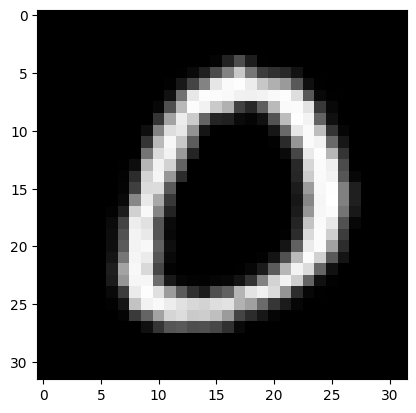

In [16]:
ax = plt.gca() 
ax.imshow(normalize(xt[5125].permute(1,2,0)), cmap='gray')

In [17]:
class GuidedVF(nn.Module, ABC):
    @abstractmethod 
    def forward(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor):
        pass 

In [18]:
class CFGVF(ODE):
    def __init__(self, net: GuidedVF, gs: float):
        self.net = net 
        self.gs = gs 
    
    def drift_term(self, x, t, y):
        guided_vf = self.net(x, t, y)
        unguided_y = torch.ones_like(y) * 10 
        unguided_vf = self.net(x, t, unguided_y)
        return (1 - gs) * unguided_vf + gs * guided_vf 

In [19]:
class Trainer(ABC):
    def __init__(self, net: GuidedVF):
        self.net = net 
    
    @abstractmethod 
    def get_train_loss(self, batch_size: int):
        pass 

    def model_size(self):
        size = 0
        for param in self.net.parameters():
            size += param.nelement() * param.element_size()
        for buffer in self.net.buffers():
            size += buffer.nelement() * buffer.element_size()
        return size / (1024**2)
        
    def get_optimizer(self, lr: float):
        return torch.optim.Adam(self.net.parameters(), lr=lr)
    
    def train(self, n_epochs: int, batch_size: int, lr: float = 1e-3):
        print(f'Training model of size {self.model_size()}')
        self.net.train()
        opt = self.get_optimizer(lr)
        
        for ep in trange(n_epochs):
            opt.zero_grad()
            loss = self.get_train_loss(batch_size)
            loss.backward()
            opt.step()
            
        self.net.eval()

In [36]:
class CFGTrainer(Trainer):
    def __init__(self, path: GCPP, net: GuidedVF, eta: float):
        super().__init__(net)
        self.path = path 
        self.eta = eta 
    
    def get_train_loss(self, batch_size: int):
        # Step 1: Sample z,y from p_data
        z, y = self.path.p_data.sample(batch_size) # z:[bs, 1, 32, 32]
        
        # Step 2: Set each label to 10 (i.e., null) with probability eta
        probs = torch.rand(y.shape)
        y[probs < self.eta] = 10.0
        
        # Step 3: Sample t and x
        ts = torch.rand(batch_size, 1, 1, 1) #ts:[bs, 1, 1, 1]
        x = self.path.sample_conditional_path(z, ts) # x: [bs, 1, 32, 32]

        # Step 4: Regress and output loss
        guided_vf = self.net(x, ts, y) # [bs, c, h, w] 
        ref_vf = path.conditional_vector_field(x, z, ts) # [bs, c, h, w]
        
        error = einsum(torch.square(guided_vf - ref_vf), 'b c h w -> b') # [bs,]
        return torch.mean(error) # [1]
                

In [21]:
class FourierEncoder(nn.Module):
    """
    timestamp is 1D data and we make it a high dimensional data
    so we are representing the 1D timestamp data higher dimension via four transform
    """
    def __init__(self, dim: int):
        super().__init__()
        assert dim % 2 == 0
        self.half = dim // 2 # the fourier consist of sin and cos, the total lenght will be d (d/2 sin, d/2 cos)-terms
        self.w = nn.Parameter(torch.randn(1, self.half))
        
    def forward(self, t):
        """
        variance of sin/cos is 1/2, to make it unit variance we should multiply it with sqrt(2), as per following rule
        var(f(x)) = p
        var(a*f(x)) = p*a^2
        """
        t = t.view(-1, 1)
        freqs = 2 * torch.pi * self.w * t
        sins = torch.sin(freqs)
        cos = torch.cos(freqs)
        return torch.cat([sins, cos], dim=-1) * torch.sqrt(torch.Tensor([2])) 

In [22]:
t = torch.randn(40, 1)
layer = FourierEncoder(40)

layer(t).shape

torch.Size([40, 40])

In [23]:
class Residual(nn.Module):
    def __init__(self, n_channels: int, t_emb_dim: int, y_emb_dim: int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.SiLU(),
            nn.BatchNorm2d(n_channels),
            nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1)
        )
        self.block2 = nn.Sequential(
            nn.SiLU(),
            nn.BatchNorm2d(n_channels),
            nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1)
        )
        self.time_adaptor = nn.Sequential(
            nn.Linear(t_emb_dim, t_emb_dim),
            nn.SiLU(),
            nn.Linear(t_emb_dim, n_channels)
        )
        self.y_adaptor = nn.Sequential(
            nn.Linear(y_emb_dim, y_emb_dim),
            nn.SiLU(),
            nn.Linear(y_emb_dim, n_channels)
        )
    
    def forward(self, x: torch.Tensor, t_emb: torch.Tensor, y_emb: torch.Tensor):
        orig = x.clone()
        x = self.block1(x)
        
        t_emb = self.time_adaptor(t_emb).unsqueeze(-1).unsqueeze(-1)
        x = x + t_emb
        
        y_emb = self.time_adaptor(y_emb).unsqueeze(-1).unsqueeze(-1)
        x = x + y_emb
        
        x = self.block2(x)
        
        return orig + x

In [24]:
class Encoder(nn.Module):
    def __init__(self, in_channel: int, out_channel :int, n_res_layers: int, t_emb_dim: int, y_emb_dim: int):
        super().__init__()
        self.res_block = nn.ModuleList([
            Residual(in_channel, t_emb_dim, y_emb_dim) for _ in range(n_res_layers)
        ])
        self.downsample = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x, t, y):
        for layers in self.res_block:
            x = layers(x, t, y)
        x = self.downsample(x)
        return x
    
class Midcoder(nn.Module):
    def __init__(self, n_channels: int, n_res_layers: int, t_emb_dim: int, y_emb_dim: int):
        super().__init__()
        self.res_block = nn.ModuleList([
            Residual(n_channels, t_emb_dim, y_emb_dim) for _ in range(n_res_layers)
        ])
    
    def forward(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor):
        for layer in self.res_block:
            x = layer(x, t, y)
        return x
    
class Decoder(nn.Module):
    def __init__(self, in_channel: int, out_channel: int, n_res_layers: int, t_emb_dim: int, y_emb_dim: int):
        super().__init__()
        self.res_block = nn.ModuleList([
            Residual(out_channel, t_emb_dim, y_emb_dim) for _ in range(n_res_layers)
        ])
        
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1)
        )
        
    def forward(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor):
        x = self.upsample(x)
        for layer in self.res_block:
            x = layer(x, t, y)
        return x
        
    

In [37]:
class MNISTUNet(GuidedVF):
    def __init__(self, channels: List[int], n_residual_layers: int, t_emb_dim: int, y_emb_dim: int):
        super().__init__()
        
        self.init_conv = nn.Sequential(
            nn.Conv2d(1, channels[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(channels[0]),
            nn.SiLU()
        )
        
        self.time_encoder = FourierEncoder(t_emb_dim)
        self.label_embed = nn.Embedding(num_embeddings=11, embedding_dim=y_emb_dim)
        
        encoders = []
        decoders = []
        
        for curr_c, next_c in zip(channels[:-1], channels[1:]):
            encoders.append(Encoder(curr_c, next_c, n_residual_layers, t_emb_dim, y_emb_dim))
            decoders.append(Decoder(next_c, curr_c, n_residual_layers, t_emb_dim, y_emb_dim))    

        self.encoders = nn.ModuleList(encoders)
        self.decoders = nn.ModuleList(reversed(decoders))
        
        self.midcoder = Midcoder(channels[-1], n_residual_layers, t_emb_dim, y_emb_dim)
        
        self.final_conv = nn.Conv2d(channels[0], 1, kernel_size=3, padding=1)
        
        
    def forward(self, x, t, y):
        
        x = self.init_conv(x)
        t = self.time_encoder(t)
        y = self.label_embed(y)
        
        residual = []
        for encoder in self.encoders:
            x = encoder(x, t, y)
            residual.append(x.clone())
        
        x = self.midcoder(x, t, y)
        
        for decoder in self.decoders:
            res = residual.pop()
            x  = x + res 
            x = decoder(x, t, y)
        
        return self.final_conv(x)

In [1]:
path = GCPP(
    p_init = IsotropicGaussian(shape=(1,32,32), std=1.0),
    p_data = MNISTSampler(),
    alpha = LinearAlpha(), 
    beta = LinearBeta()
)

unet = MNISTUNet(
    channels=[32, 64, 128], 
    n_residual_layers=2, 
    t_emb_dim=40, 
    y_emb_dim=40
)

trainer = CFGTrainer(path=path, net=unet, eta=0.1)
trainer.model_size()


NameError: name 'GCPP' is not defined

In [42]:
trainer.train(n_epochs=5000, lr=1e-3, batch_size=250)

Training model of size 4.714931488037109


  0%|          | 17/5000 [01:14<6:02:30,  4.37s/it]


KeyboardInterrupt: 

In [ ]:
# Play with these!
samples_per_class = 10
num_timesteps = 100
guidance_scales = [1.0, 3.0, 5.0]

# Graph
fig, axes = plt.subplots(1, len(guidance_scales), figsize=(10 * len(guidance_scales), 10))

for idx, w in enumerate(guidance_scales):
    # Setup ode and simulator
    ode = CFGVectorFieldODE(unet, guidance_scale=w)
    simulator = EulerSimulator(ode)

    # Sample initial conditions
    y = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=torch.int64).repeat_interleave(samples_per_class).to(device)
    num_samples = y.shape[0]
    x0, _ = path.p_simple.sample(num_samples) # (num_samples, 1, 32, 32)

    # Simulate
    ts = torch.linspace(0,1,num_timesteps).view(1, -1, 1, 1, 1).expand(num_samples, -1, 1, 1, 1).to(device)
    x1 = simulator.simulate(x0, ts, y=y)

    # Plot
    grid = make_grid(x1, nrow=samples_per_class, normalize=True, value_range=(-1,1))
    axes[idx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[idx].axis("off")
    axes[idx].set_title(f"Guidance: $w={w:.1f}$", fontsize=25)
plt.show()